# 2D Derivative Gaussian Process
## Theory Background
Suppose we are sampling functions defined in $\mathbb{R}^{2}$ with a Gaussian Process (GP). Following the notation from the previous notebook, $f \sim \mathcal{GP}(\mu_{f}, k_{ff}). The function and its partial derivatives, $f,f_x, f_y$ are sampled from an augmented GP with the following mean function and kernel function.
$$ \mu = [\mu_f \ \mu_x \ \mu_y] \ ; \ k = 
\begin{bmatrix} 
    k_{ff} &  k_{fx} & k_{fy} \\ 
    k_{xf} &  k_{xx} & k_{xy} \\
    k_{yf} &  k_{yx} & k_{yy} \\
\end{bmatrix} , $$
As in the 1D case, the rows (columns) in the augmented kernel matrix correspond to different values of the kernel's first (second) argument. Here, we use notation that is different from the previous section. Let $\mathbf{x_{i}} = (x_i , y_i)$. Then, 
$$ \mu_x = \frac{\partial \mu_f}{\partial x} \ ; \ \mu_y = \frac{\partial \mu_f}{\partial y} $$
$$ k_{xf} = \frac{\partial k_{ff}(\mathbf{x}_{1}, \mathbf{x}_{2})}{\partial x_{1}} \ ; \ k_{fx} = \frac{\partial k_{fx}(\mathbf{x}_{1}, \mathbf{x}_{2})}{\partial x_{2}} \ ; \ k_{yf} = \frac{\partial k_{ff}(\mathbf{x}_{1}, \mathbf{x}_{2})}{\partial y_{1}} \ ; \ ... \ ; \ k_{xy} = \frac{\partial k_{ff}(\mathbf{x}_{1}, \mathbf{x}_{2})}{\partial x_{1} \partial y_{2}} $$

As before, we can sample function values, x-derivatives, and y-derivatives at different points. I.e., $f$ can be sampled at inputs $\{ \mathbf{x}_{i} \}_{i}$, $f_x$ at $\{ \mathbf{x}_{Dx, i} \}_{i}$, and $f_y$ at $\{ \mathbf{x}_{Dy, i} \}_{i}$.

## `Tinygp` Implementation of Derivative Kernel

### Reference:
The cell below follows the same technique used in the `tinygp` tutorial on [Derivative Observations & Pytree Data][1]. Another useful tutorial is the one on [Multivariate Data][2].

[1]: <https://tinygp.readthedocs.io/en/stable/tutorials/derivative.html> "Derivative Observations & Pytree Data"
[2]: <https://tinygp.readthedocs.io/en/latest/tutorials/multivariate.html> "Multivariate Data"

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tinygp import GaussianProcess, kernels, transforms

# 2D Derivative Kernel
class DerivativeKernel(kernels.Kernel):
    """
    A kernel that takes the derivative of another kernel with respect to one of its
    arguments. The argument to be differentiated with respect to is specified by the
    boolean flags d1x, d1y, d2x, d2y. For example, if d1x is True, then the kernel
    will be differentiated with respect to the first argument's x-coordinate.

    This kernel is useful for computing the derivatives of a Gaussian process with
    respect to its inputs.

    Parameters
    ----------
    kernel : Kernel
        The kernel to differentiate.
    d1x : bool (0,1)
        Whether to differentiate with respect to the first argument's x-coordinate.
    d1y : bool (0,1)
        Whether to differentiate with respect to the first argument's y-coordinate.
    d2x : bool (0,1)
        Whether to differentiate with respect to the second argument's x-coordinate.
    d2y : bool (0,1)
        Whether to differentiate with respect to the second argument's y-coordinate.

    Returns
    -------
    DerivativeKernel
        A kernel that computes the derivative of the given kernel with respect to
        the specified arguments.
    """
    def __init__(self, kernel):
        self.kernel = kernel
    def evaluate(self, X1, X2):
        """
        Evaluate the kernel matrix and its derivatives.

        Parameters
        ----------
        X1 : array-like, shape=(n_samples, 2)
            The first set of samples.
        X2 : array-like, shape=(n_samples, 2)
            The second set of samples.
        
        Returns
        -------
        array-like, shape=(n_samples, n_samples)
            The kernel matrix.
        """

        x1, y1, d1x, d1y = X1
        x2, y2, d2x, d2y = X2

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(jnp.array([x1,y1]), jnp.array([x2,y2]))
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(lambda x2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2_,y2])))(x2)
        dK_dx1 = jax.grad(lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2])))(x1)
        d2K_dx1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2_,y2]))) )(x1) 
            ) )(x2) 
        
        dK_dy2 = jax.grad(lambda y2_: self.kernel.evaluate(jnp.array([x1,y1]),jnp.array([x2,y2_])))(y2)
        dK_dy1 = jax.grad(lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2])))(y1)
        d2K_dy1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2,y2_]))) )(y1) 
            ) )(y2) 
        
        d2K_dx1dy2 = (jax.grad( lambda y2_: 
            ( jax.grad( lambda x1_: self.kernel.evaluate(jnp.array([x1_,y1]),jnp.array([x2,y2_]))) )(x1) 
            ) )(y2) 
        d2K_dy1dx2 = (jax.grad( lambda x2_: 
            ( jax.grad( lambda y1_: self.kernel.evaluate(jnp.array([x1,y1_]),jnp.array([x2_,y2]))) )(y1) 
            ) )(x2) 
        return jnp.where(d1x, 
                         jnp.where(d2x, d2K_dx1dx2, jnp.where(d2y, d2K_dx1dy2, dK_dx1)),
                         jnp.where(d1y, jnp.where(d2x, d2K_dy1dx2, jnp.where(d2y, d2K_dy1dy2, dK_dy1)), 
                                   jnp.where(d2x, dK_dx2, jnp.where(d2y, dK_dy2, K)))
                                   )

## Example: Zero-Mean GP

We plot a GP sample $\mathbf{f}$ and its corresponding derivative GP samples $\mathbf{f}_x, \mathbf{f}_y$, evaluated at the same inputs as the original function. We compare the derivative GP sample to the approximate derivative of the sample, computed using finite differences.

In [2]:
# Verify that derivative kernel gives the right partial derivatives
# with an example (ExpSquared Kernel)

# create a grid of inputs (NOTE: GP -> ~10 GP ; use less datapoints if necessary)
x1_plt = np.linspace(-1.5, 1.5, 46)
x2_plt = np.linspace(-1.5, 1.5, 46)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = np.meshgrid(x1_c, x2_c)
x = np.stack([x1, x2], axis=-1)

# reshape data to (N_data,2)
Nx, Ny = x.shape[:-1]
x_f = x.reshape((Nx*Ny,2))

# kernel parameters
mean = 0.
amp = 1.
scale = 0.25

# augment data
x3 = jnp.concatenate([x_f,x_f,x_f])
d3x = jnp.concatenate([jnp.zeros(x_f.shape[0]),jnp.ones(x_f.shape[0]),jnp.zeros(x_f.shape[0])])
d3y = jnp.concatenate([jnp.zeros(x_f.shape[0]),jnp.zeros(x_f.shape[0]),jnp.ones(x_f.shape[0])])
x_aug = jnp.vstack([x3.T,d3x.T,d3y.T]).T

# Create kernel
unit_kernel = kernels.ExpSquared(distance = kernels.distance.L2Distance()) # L2Distance will allow kernel to remain differentiable (necessary for non-ExpSquared kernels)
scale = jnp.ones(()) / scale # length scale parameter setting equivalent to rescaling inputs by inverse length scale
base_kernel = amp * transforms.Linear(scale, unit_kernel)
kernel = DerivativeKernel(base_kernel)

# Create GP
gp = GaussianProcess(kernel, x_aug, mean=mean, diag = 1e-4)

# generate sample
sample = gp.sample(jax.random.PRNGKey(11))

Text(0, 0.5, 'y')

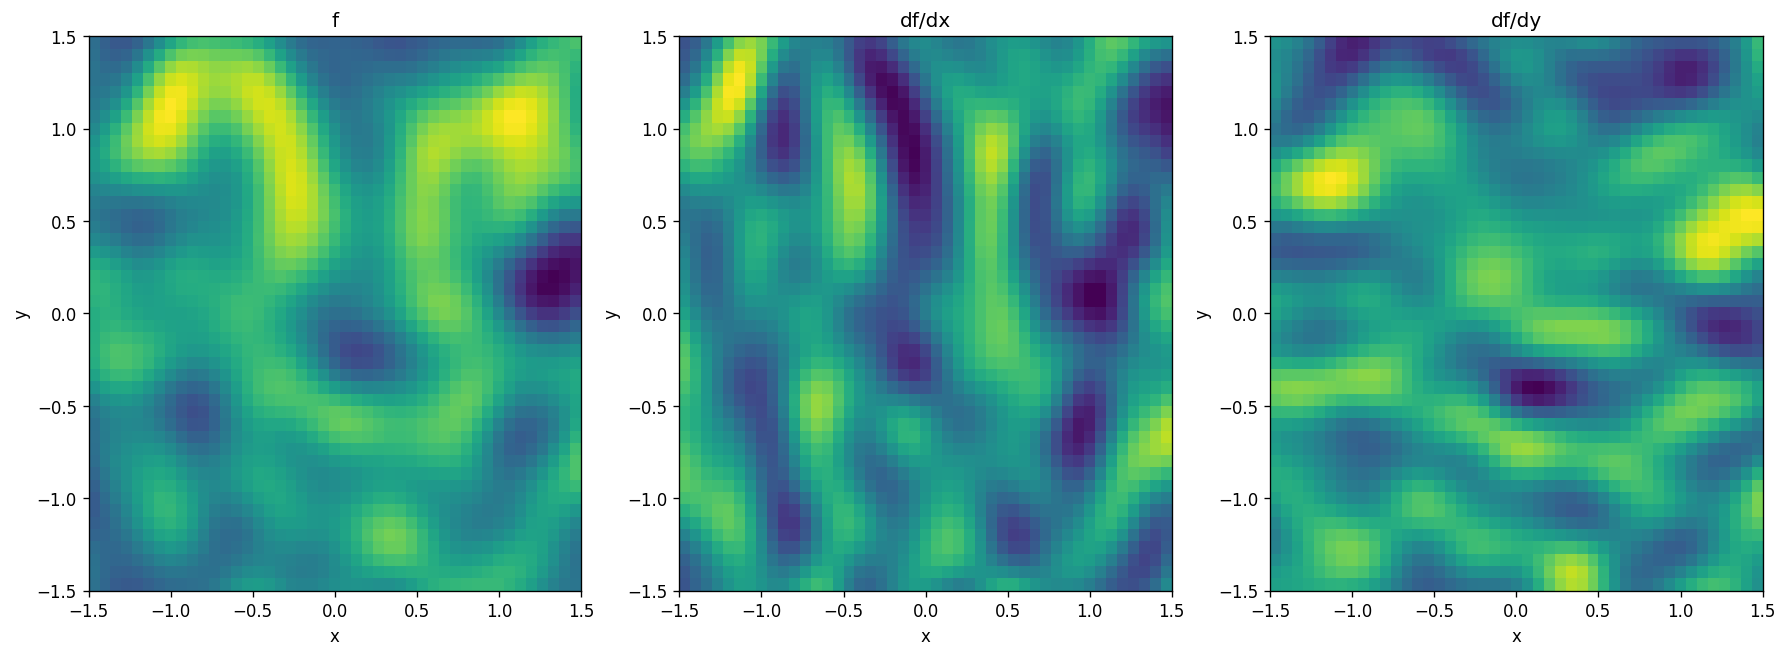

In [3]:
# generate map of function values and derivatives

Nxf = x_f.shape[0] # number of inputs (index value that divides functions and x-derivatives)
Nxf2 = 2 * Nxf  # 2 * number of inputs(index value that divides x-derivatives and y-derivatives)
Nx, Ny = x.shape[:-1] # dimensions of grid

fig = plt.figure(figsize=(18, 6), dpi= 120)

ax = fig.add_subplot(131)
f = sample[:Nxf]
f_r = f.reshape(Nx,Ny) # reshape flattened sample to grid
ax.pcolormesh(x1_plt, x2_plt, f_r, cmap='viridis')
ax.set_title('f')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(132)
fpx = sample[Nxf:Nxf2]
fpx_r = fpx.reshape(Nx,Ny) # reshape flattened sample to grid
ax.pcolormesh(x1_plt, x2_plt, fpx_r, cmap='viridis')
ax.set_title('df/dx')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(133)
fpy = sample[Nxf2:]
fpy_r = fpy.reshape(Nx,Ny) # reshape flattened sample to grid
ax.pcolormesh(x1_plt, x2_plt, fpy_r, cmap='viridis')
ax.set_title('df/dy')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0.5, 1.0, 'Function Map')

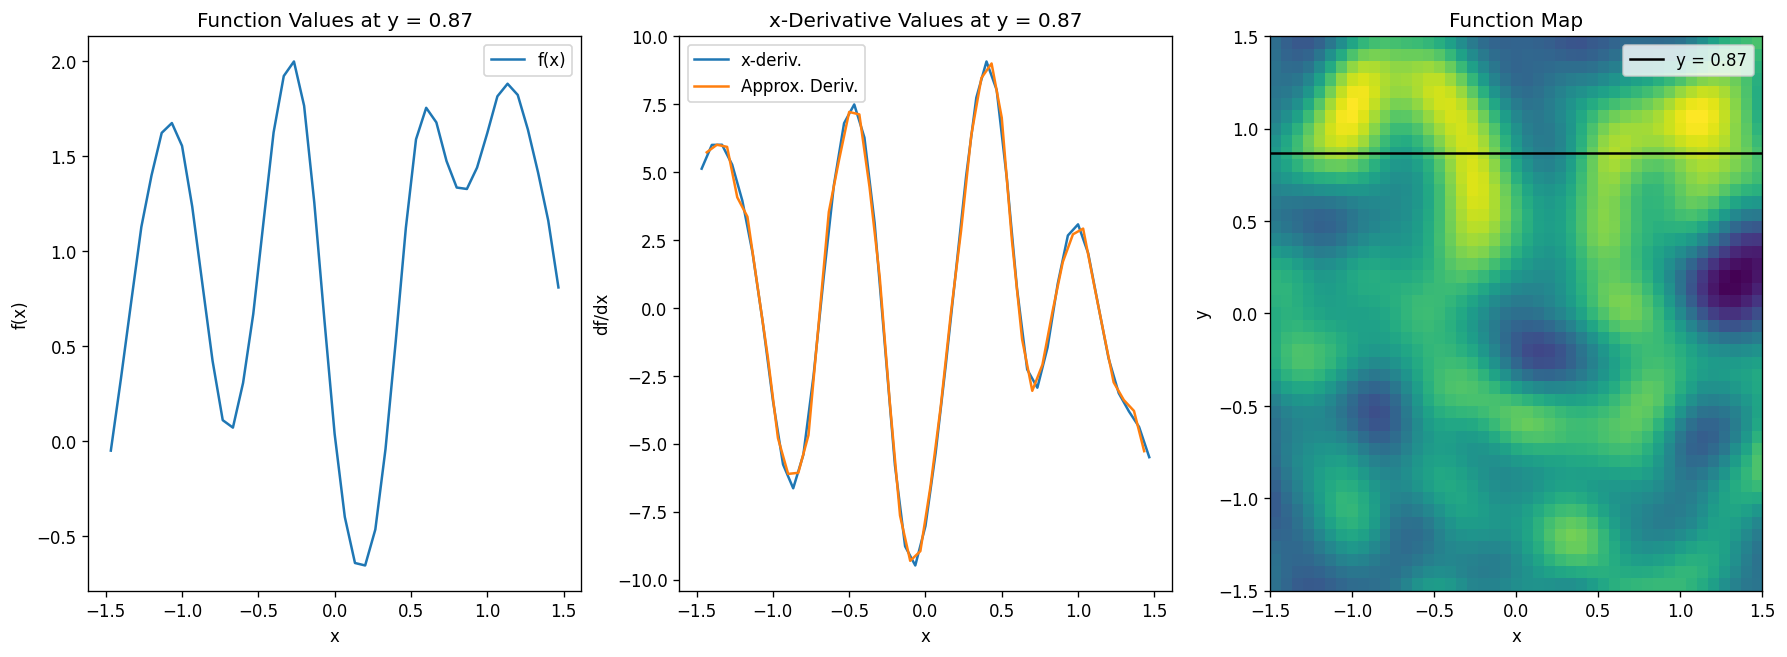

In [4]:
# generate function values and derivatives on 1D horizontal slice to compare x-derivative with finite differences

# specify horizontal slice
ny = 35 # y index
xlist = x[ny,:,0]
y_val = x[ny,:,1][0]

# extract x-derivatives and reshape to grid
fx = sample[Nxf:Nxf2]
fx_r = fx.reshape(Nx,Ny)

# obtain function values and x-derivatives on slice
flist = f_r[ny,:]
fxlist = fx_r[ny,:]

# start plotting
fig = plt.figure(figsize=(18, 6), dpi= 120)

# plot function w.r.t. x
ax = fig.add_subplot(131)
ax.plot(xlist, flist, label='f(x)')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.set_title('Function Values at y = {}'.format(round(y_val, 2)))

# plot x-derivative
ax = fig.add_subplot(132)
ax.plot(xlist, fxlist, label='x-deriv.')

# empirical derivative
x_center = (xlist[1:] + xlist[:-1]) / 2
dx = np.diff(xlist)
df = np.diff(flist)
approx_deriv = df / dx

ax.plot(x_center, approx_deriv, label='Approx. Deriv.')
ax.set_xlabel('x')
ax.set_ylabel('df/dx')
ax.legend()
ax.set_title('x-Derivative Values at y = {}'.format(round(y_val, 2)))

# indicate horizontal slice in function map
ax = fig.add_subplot(133)
ax.pcolormesh(x1_plt, x2_plt, f_r, cmap='viridis')
ax.axhline(y = y_val, ls = '-', c = 'k', label = 'y = {}'.format(round(y_val, 2)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Function Map')

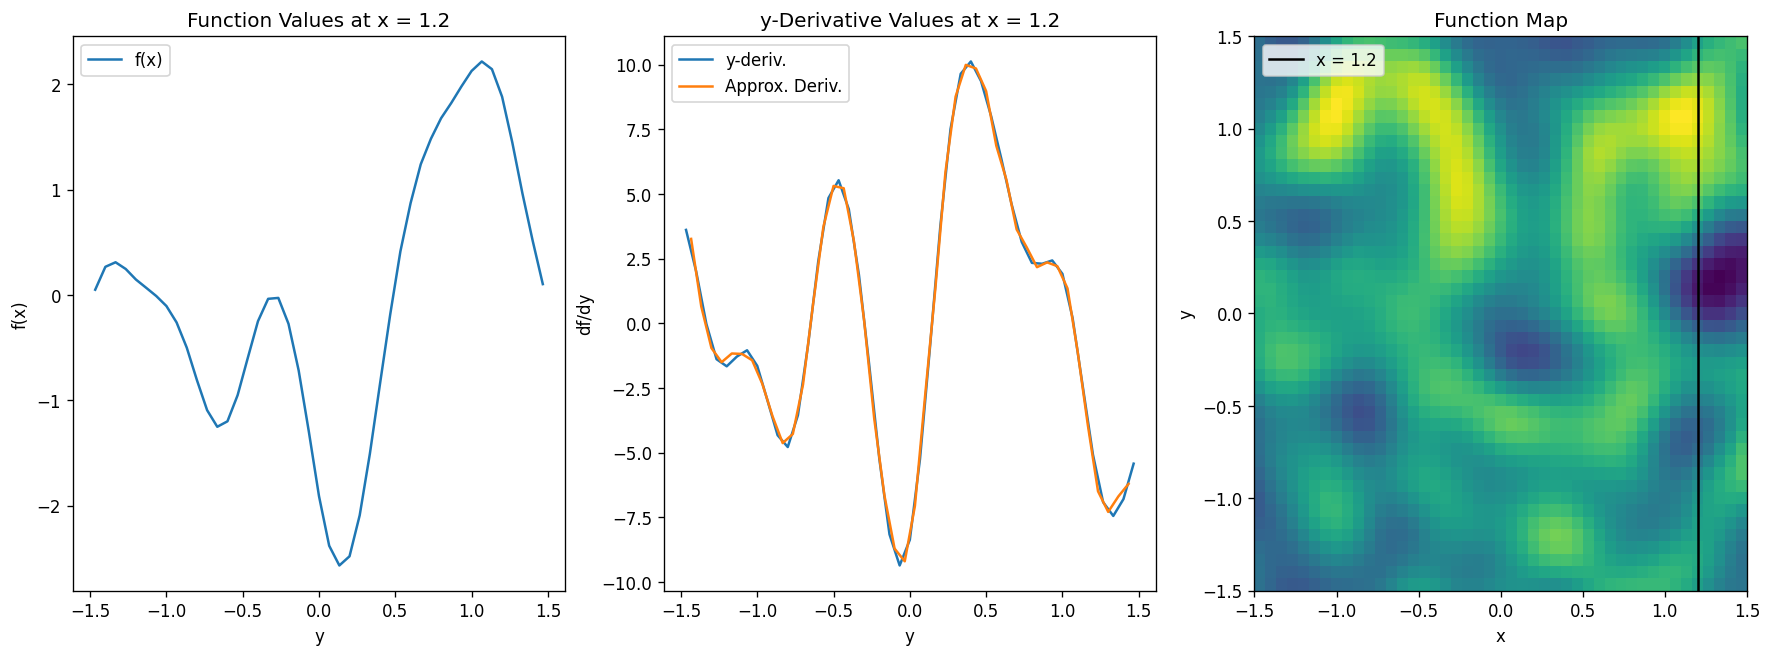

In [5]:
# generate function values and derivatives on 1D vertical slice to compare y-derivative with finite differences

# specify vertical slice
nx = 40 # y index
ylist = x[:,nx,1]
x_val = x[:,nx,0][0]

# extract y-derivatives and reshape to grid
fy = sample[Nxf2:]
fy_r = fy.reshape(Nx,Ny)

# obtain function values and y-derivatives on slice
flist = f_r[:,nx]
fylist = fy_r[:,nx]

# start plotting
fig = plt.figure(figsize=(18, 6), dpi= 120)

# plot function w.r.t. x
ax = fig.add_subplot(131)
ax.plot(ylist, flist, label='f(x)')
ax.set_xlabel('y')
ax.set_ylabel('f(x)')
ax.legend()
ax.set_title('Function Values at x = {}'.format(round(x_val, 2)))

# plot y-derivative
ax = fig.add_subplot(132)
ax.plot(ylist, fylist, label='y-deriv.')

# empirical derivative
y_center = (ylist[1:] + ylist[:-1]) / 2
dy = np.diff(ylist)
df = np.diff(flist)
approx_deriv = df / dy

ax.plot(y_center, approx_deriv, label='Approx. Deriv.')
ax.set_xlabel('y')
ax.set_ylabel('df/dy')
ax.legend()
ax.set_title('y-Derivative Values at x = {}'.format(round(x_val, 2)))

# indicate horizontal slice in function map
ax = fig.add_subplot(133)
ax.pcolormesh(x1_plt, x2_plt, f_r, cmap='viridis')
ax.axvline(x = x_val, ls = '-', c = 'k', label = 'x = {}'.format(round(x_val, 2)))
ax.set_title('Function Map')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()